In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy import interpolate
import matplotlib.colors as colors
from matplotlib import style
from matplotlib.patches import Rectangle

In [2]:
x = np.random.randn(5,)
B = np.full((5,5), np.ones(1,))
print(x @ B @ x)


28.31557098932742


In [3]:
#Bootstrap Particle Filter functions (Additive Gaussian)
def Measurement_Likelihood(gx,y,R_y):
# Calculates normalized likelihood
    helper1=-1/2*(y-gx)*(y-gx) * R_y**-1 #np.linalg.inv(R_y) #(2 x N)' times (2 x 2) times (2 x N)= (N x N) np.linalg.inv(R_y) when R_y is 2 x 2
#    Likelihoods=np.exp(np.diag(helper1)) #Off diagonal are cross-terms
    Likelihoods=np.exp(helper1)
    Likelihoods=Likelihoods/Likelihoods.sum() #Normalizing Likelihoods vector
    return Likelihoods

def Resampler(particles,weights):
    x_resampled=np.full(particles.shape, np.nan)
    weights=weights/weights.sum() #Normalize weights
    CDF=weights.cumsum() #Finding the cummulative distribution function (its range)
    for i in range(weights.size):
        I=np.array(np.where(CDF>=random.uniform(0,1))) #CDF inverse of a uniformly sampled point in (0,1)
        x_resampled[:,i]=particles[:,I.min()] #Corresponding particle
    return x_resampled

def TimeUpdate(Xi,var_w,var_v,u): #Propagates the particle filter
    Xiplus=np.full((Xi.shape), np.nan)
    helper=Xi.shape
    W0=np.sqrt(var_w)@np.random.randn(helper[0],helper[1])
    V=np.sqrt(var_v)@np.random.randn(helper[0],helper[1])
    
    Xiplus[0,:]=0.9*Xi[0,:]+0.2*Xi[1,:]+W0[0,:]
    Xiplus[1,:]=-0.15*Xi[0,:]+0.9*Xi[1,:]+0.05*Xi[0,:]*Xi[1,:]+u+W0[1,:]
    gx=Xiplus[0,:]+V[0,:];
    return Xiplus, gx

In [4]:
# System, controller, prerequisites of State Selection Algorithm:

def controller(state): #Here you define your controller, whether an MPC, SMPC, CBF, PID, whatever...
    u=-0.05*state[0]*state[1]
    return u

def dynamics(state,u,w):
    statePlus=np.full(state.shape,np.nan)
    statePlus[0]=0.9*state[0]+0.2*state[1]+w[0]
    statePlus[1]=-0.15*state[0]+0.9*state[1]+0.05*state[0]*state[1]+u+w[1]
    return statePlus

def f_primeN(x0prime,N,Wprime): #Generating state sequence x_k' for k=0,...,N-1
    xkprime=np.full((2, N), np.nan)
    xkprime[:,0]=x0prime
    for k in range(N-1):
        xkprime[:,k+1]=dynamics(xkprime[:,k],controller(xkprime[:,k]),Wprime[:,k])   
    return xkprime

def f2_primeN(x02prime,xkprimeW,N,W2prime): #Generating state sequence x_k'' for k=0,...,N-1
    xk2prime=np.full((2, N+1), np.nan)
    xk2prime[:,0]=x02prime.reshape(2,)
    for k in range(N):
        u=controller(xkprimeW[:,k])
        xk2prime[:,k+1]=dynamics(xk2prime[:,k],u,W2prime[:,k])    
    return xk2prime

In [5]:
# State Selection Algorithm and related functions
def StateSelector(N,M,L,alpha,Xi,var_w):
    Cost=np.zeros((L,))
    StatX=np.zeros((N, L))
    StatU=np.zeros((N,L))
    Feasibility=np.full((L,), False)
    for i in range(L):
        x0prime=Xi[:,i]
        check=Constraints(0,x0prime,10**6)
        if (check[0]==1): # Ignore state estimates inside constraints
            continue
        
        Wprime=np.sqrt(0 * var_w)@np.random.randn(2, N)    
        xkprimeW=f_primeN(x0prime,N,Wprime)
        for j in range(M): # M samples from xi_i to check statistical feasibility and sample average cost
            x02prime=Xi[:,random.sample(range(0, L), 1)]
            W2prime=np.sqrt(var_w)@np.random.randn(2, N)
            
            xk2primeW=f2_primeN(x02prime,xkprimeW,N,W2prime)
            ConstraintX, ConstraintU =checkConstraints(xkprimeW,xk2primeW,Ulim,N)
            StatX[:,i]+=ConstraintX.reshape(N,)
            StatU[:,i]+=ConstraintU.reshape(N,)
            Cost[i]+=(xkprimeW**2).sum()+(xk2primeW**2).sum()
        Feasibility[i]=all(StatX[:,i]/M < alpha)&all(StatU[:,i]/M < alpha)
    minCost=Cost[np.where(Feasibility==True)].min()
    x0star=Xi[:,np.where(Cost==minCost)]
    return x0star

def Constraints(u,state,Ulim):
    ConstraintX=0
    ConstraintU=0
    x=state[0]
    y=state[1]
    if ((3<x<5)&(-4<y<2)|(-2<x<5)&(-7<y<-4)):
            ConstraintX=1
    if (abs(u)>Ulim):
            ConstraintU=1
    return np.array([ConstraintX, ConstraintU])


def checkConstraints(xkprimeW,xk2primeW,Ulim,N): # Count constraints violations
    Violation_X=np.zeros([1, N])
    Violation_U=np.zeros([1, N])
    for k in range(N):
        u=controller(xkprimeW[:,k])
        x=xk2primeW[:,k+1]
        Check_constraints=Constraints(u,x,Ulim)
        Violation_X[0,k]=Check_constraints[0]
        Violation_U[0,k]=Check_constraints[1]
    return Violation_X, Violation_U


def AchievedAlpha(Xi): #calculates violation rates
    AlphaAchieved=0
    N=Xi.shape[1]
    for i in range(N):
        x=Xi[:,i]
        check=Constraints(0,x,10**6)
        AlphaAchieved += check[0]


    AlphaAchieved=AlphaAchieved/N
    return AlphaAchieved

In [6]:
# A function to prepare the figure, its size, and plot the constraints set.
def Constraintsplot():
    fig= plt.figure(figsize=(3.5,3.0))
    rectangle = plt.Rectangle((-2,-7), 7, 3, fc='None',ec="grey", hatch='xx',zorder=0)
    plt.gca().add_patch(rectangle)
    rectangle = plt.Rectangle((3,-4), 2, 6, fc='None',ec="grey", hatch='xx',zorder=0)
    plt.gca().add_patch(rectangle)
    plt.axis('scaled')
    pass

0


ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

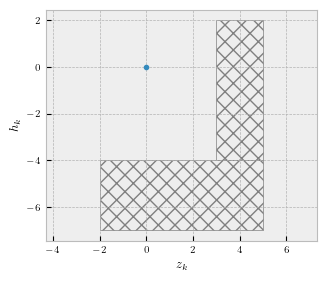

In [10]:
plt.style.use('bmh')
Constraintsplot()
plt.plot(0,0,'.')
plt.axis('equal')
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('$z_k$', fontsize=9)  
plt.ylabel('$h_k$', fontsize=9) 
plt.rc( 'text', usetex=True )
N=5 #The horizon length (minus one, since N+1 step will be evaluated in the code)
L=400 #The number of particles in $\Xi$
M=135 #Number of simulations for statistical feasibility check
alpha=0.1
Ulim=3
T=30


var_x0=np.diag(np.array([0.5,0.5]))
mu_x0=np.array([[7.5,-7.5]]).T
#mu_x0=np.array([[7,0]]).T
var_w=np.diag(np.array([0.3,0.3]))
var_v=np.diag(np.array([0.3,0.3]))
Xi0=mu_x0+np.sqrt(var_x0)@np.random.randn(2, L)
x_true=np.full((2,T+1), np.nan)
x_true[:,0]=(mu_x0+np.sqrt(var_x0)@np.random.randn(2, 1)).reshape(2,)
Xi=Xi0+0
AlphaAchieved=np.full((1,T+1), np.nan)
t = time.time()
for k in range(T):
    print(k)
    AlphaAchieved[0,k]=AchievedAlpha(Xi)
    x0star=StateSelector(N,M,L,alpha,Xi,var_w)
    plt.plot(Xi[0,:],Xi[1,:],'o', markersize=1.1,color=list(colors.cnames)[k+22], zorder=2)
    plt.plot(x0star[0],x0star[1],marker='s',ms=4, color = 'black' ,mfc=list(colors.cnames)[k+22], zorder=3)
    u=controller(x0star)
    Xiplus, gx=TimeUpdate(Xi,var_w,var_v,u)
    y=x_true[0,k]+np.sqrt(var_v)[0,0]*np.random.randn()
    disturbance_k=np.sqrt(var_w)@np.random.randn(2, 1)
    x_true[:,k+1]=(dynamics(x_true[:,k],u,disturbance_k)).reshape(2,)
    Likelihoods=Measurement_Likelihood(np.array([gx]),y,var_v[0,0])
    Xi=Resampler(Xiplus,Likelihoods)
    plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
    plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
    plt.savefig('L_example_SS.pdf',bbox_inches ="tight")

AlphaAchieved[0,T]=AchievedAlpha(Xi)  
print('Computation Time =',time.time()-t)    


plt.show()




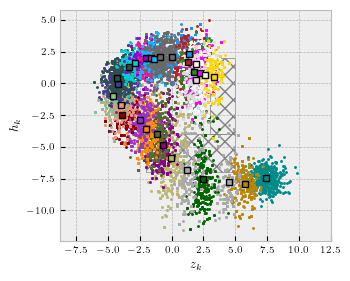

In [ ]:
#With particle filter conditional mean
Constraintsplot()
#x=[2,4,4,-2,-2,2,2]
#y=[4,4,-6,-6,-4,-4,4]
#plt.plot(x,y)
plt.plot(0,0,'.')
AlphaAchievedCM=np.full((1,T+1), np.nan)
plt.axis('equal')
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('$z_k$', fontsize=9)  
plt.ylabel('$h_k$', fontsize=9) 
#plt.xlabel('$z_k^{\prime\prime}$')  
#plt.ylabel('$h_k^{\prime\prime}$') 
Xi=Xi0
x_true=np.full((2,T+1), np.nan)
x_true[:,0]=(mu_x0+np.sqrt(var_x0)@np.random.randn(2, 1)).reshape(2,)
for k in range(T):
    AlphaAchievedCM[0,k]=AchievedAlpha(Xi)
    x0mean=np.sum(Xi, axis=1)/L
    plt.plot(Xi[0,:],Xi[1,:],'o', markersize=1.1,color=list(colors.cnames)[k+22],zorder=2)
    plt.plot(x0mean[0],x0mean[1],marker='s',ms=4, color = 'black' ,mfc=list(colors.cnames)[k+22], zorder=3)
    u=controller(x0mean)
    Xiplus, gx=TimeUpdate(Xi,var_w,var_v,u)
    y=x_true[0,k]+np.sqrt(var_v)[0,0]*np.random.randn()
    disturbance_k=np.sqrt(var_w)@np.random.randn(2, 1)
    x_true[:,k+1]=(dynamics(x_true[:,k],u,disturbance_k)).reshape(2,)
    Likelihoods=Measurement_Likelihood(np.array([gx]),y,var_v[0,0])
    Xi=Resampler(Xiplus,Likelihoods)

AlphaAchievedCM[0,T]=AchievedAlpha(Xi)          
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.rc('axes', labelsize=7) #fontsize of the x and y labels
plt.savefig('L_example_CM.pdf',bbox_inches ="tight")
plt.show()



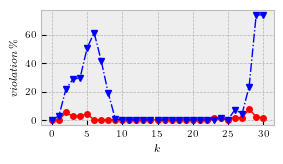

In [ ]:
# Generating the violation rates figure
plt.style.use('bmh')
plt.figure(figsize=(3.0,1.5))
plt.plot(AlphaAchieved[0,:]*100,'-or', linewidth=1, ms=4)
plt.plot(AlphaAchievedCM[0,:]*100,'-.vb', linewidth=1, ms=4)
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels

plt.xlabel('$k$', fontsize=8)  
plt.ylabel('$violation\,\%$', fontsize=8) 
plt.savefig('AchievedAlpha_StabilizingK.pdf',bbox_inches ="tight")

plt.show()